# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio
- Buscar uma forma de determinar a renda de um determinado individuo baseado  em  informações coletadas do mesmo. Utilizaremos para nosso trabalho a base histórica de 'previsao_de_renda.csv' que contém informações de diversas pessoas. 




## Etapa 2 Crisp-DM: Entendimento dos dados

- Abaixo temos uma tabela com a descrição e entendimento das informações disponíveis para criarmos um modelo de previsão de renda.

### Dicionário de dados



| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| Unnamed                 |  Coluna sem função - eliminar                       |   Inteiro    |
| data_ref                |  Data de referência para o registro                 |    Texto     |
| index                   |  Identificador do Cliente                           |   Inteiro    |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    |     M/F      |
| posse_de_veiculo        |  Y = 'possui'; N = 'não possui'                     |     Y/N      | 
| posse_de_imovel         |  Y = 'possui'; N = 'não possui'                     |     Y/N      |
| qtd_filhos              |  Quantidade de filhos                               |   Inteiro    |
| tipo_renda              |  Tipo de renda (ex: assaliariado, autônomo etc)     |    Texto     |
| educacao                |  Nível de educação (ex: secundário, superior etc)   |    Texto     |
| estado_civil            |  Estado civil (ex: solteiro, casado etc)            |    Texto     |
| tipo_residencia         |  tipo de residência (ex: casa/apartamento,etc)      |    Texto     |
| idade                   |  Idade em anos                                      |   Inteiro    |
| tempo_emprego           |  Tempo de emprego em anos                           |   Inteiro    |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                |   Inteiro    |
| mau                     |  False = 'Bom Pagador; True = 'Mau Pagador'         |   Boleana    |
| renda                   |  Valor da renda mensal bruta                        |   Decimal    |





### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

- Para utilizarmos as facilidades de verificação das informações sobre nossa base de dados vamos utilizar o ProfileReport, para tanto necessitamos instala-lo. Segue comando para instalação: pip install pandas-profiling. O comando abaixo executado pelo jupyter notebook deu erro, tive que instalar o pandas-profiling pelo prompt de comando do windows.

In [20]:
#!pip install pandas-profiling 

##### Carregando Bibliotecas importantes para nosso trabalho.
    - Pandas para o carregamento e tratamento de arquivo
    - Numpy para efetuar calculos estatíticos como média, mínimo, máximo, etc...
    - ProfileReport para gerar um resumo detalhado do conteúdo das variáveis do nosso arquivo.
    - Sklearn.model_selection para separar dados em treino e teste para rodar regressão linear
    - Patsy para facilitar o processo de criar uma regressão
    - Statsmodel.api para facilitar o processo de rodar regressão linear
    - matplotlib.pyplot para fazer gráficos
    - seaborn para fazer gráficos

In [21]:
import pandas as pd
import numpy as np
import patsy 
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error

### Funções utilizadas 

In [22]:
# Verificação de outliers
def det_outliers(df_1, campo, met='quartil'):
    q1=df_1[campo].quantile(0.25)
    q3=df_1[campo].quantile(0.75)
    print(f'primeiro quartil = {round(q1,2)} e terceiro = {round(q3,2)}')
    if met == 'quartil':
        #Método do Quartil
        iqr = q3-q1
        lim_inf= q1 - (iqr * 1.5)
        lim_sup= q1 + (iqr * 1.5)
        print('Método Quartil')
        print(f'Limite inferior = {round(lim_inf,2)} e limite superior = {round(lim_sup,2)}')
        return lim_inf, lim_sup
    else:
        #método do desvio padrão
        media = np.mean(df_1[campo])
        desvio = np.std(df_1[campo])
        cut_off = desvio * 3
        lim_inf_dev = media - cut_off
        lim_sup_dev = media + cut_off
        print('Método Desvio Padrão')
        print(f'Limite inferior = {round(lim_inf_dev,2)} e limite superior = {round(lim_sup_dev,2)}')
        return lim_inf_dev, lim_sup_dev 
   

In [23]:
####Executando o modelo proposto de stepwise
def stepwise_selection(X, y, 
                        initial_list=[], 
                        threshold_in=0.01, 
                        threshold_out = 0.05, 
                        verbose=True):
        """ Perform a forward-backward feature selection 
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features 
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        #print("included")
        #print(included)
       
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = pd.Series(index=excluded)
            
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()                
                print("modelo 1")
                print(model.summary())
                new_pval[new_column] = model.pvalues[new_column]
                print("new_pval")
                print(new_pval)
                
            best_pval = new_pval.min()
            print("best_pval")
            print(best_pval)      
            if best_pval < threshold_in:
                print("best_pval")
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print("Entrou")
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
              
            
            #sys.exit()
            # backward step
            #model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            print("modelo 2")
            print(model.summary())
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            print("worst_pval")
            print(worst_pval) 
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

#result = stepwise_selection(X, y)

#print('resulting features:')
#print(result)


#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [24]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [25]:
renda.head(1)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.60274,1.0,8060.34


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [26]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### Para facilitar a análise e melhorar a visualização das informações contidas no relatório gerado pelo ProfileReport, vamos exportar os dados para um arquivo html. 

In [27]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Entendimento dos dados - Bivariadas




O arquivo analisado tem 15000 linhas e 2.573 celulas faltando dados. Temos em torno de 1.1% de dados faltantes, isto nos mostra que se deletarmos estas linhas com dados faltantes não vamos prejudicar nossa análise uma vez que o percentual de dados faltantes é muito pequeno. 
Temos 15 variáveis, das quais 7 são númericas, 6 são categoricas e 2 boleanas. A variável unnamed tem 15000 números distintos indo de 0 à 14.999, vamos eliminá-la pois dever ser somente um número sequêncial de entradas no arquivo. A variável id_cliente e data_ref também serão eliminadas, pois não trarão nenhum benefício para nosso modelo. As variáveis categoricas serão análisadas e criaremos dummies para entrada em nosso modelo, as variáveis boleanas vão sofrer também o mesmo tratamento para utilizarmos no nosso modelo de previsão. 

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



### Preparação dos dados do arquivo



In [28]:
# Eliminação de colunas que não serão utilizados no modelo e registros com dados faltantes. 
renda.drop(columns=['Unnamed: 0','data_ref','id_cliente'],inplace=True)
renda = renda.dropna()
renda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


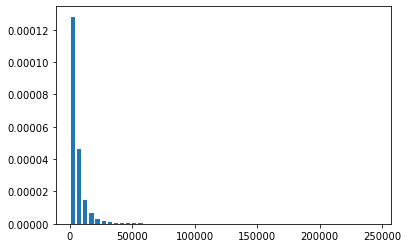

In [29]:
#Verificação da distribuição da variável renda.
renda_aux = renda['renda']
plt.hist(renda_aux, density=True, bins=50,rwidth=0.7) 
plt.show()

In [30]:
# Verificação e eliminação de outliers
limites= det_outliers(renda,'renda',met='x')
renda = renda[(renda['renda'] >= limites[0]) & (renda['renda'] <= limites[1])]
print(renda.shape)

primeiro quartil = 2117.23 e terceiro = 6846.65
Método Desvio Padrão
Limite inferior = -20552.57 e limite superior = 32785.65
(12239, 12)


In [31]:
#Criação de variáveis dummies
df_dummies_renda = pd.get_dummies(renda, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel','tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])
print(df_dummies_renda.columns)
#eliminando colunas dos dummies que não serão utilizadas no modelo e organizando o dataframe
df_dummies_renda.drop(columns=['sexo_M', 'posse_de_veiculo_True','posse_de_imovel_False','tipo_renda_Bolsista'
                               , 'educacao_Pós graduação','estado_civil_Viúvo', 'tipo_residencia_Estúdio'], inplace=True)
print(df_dummies_renda.columns)
#Organizando
df_dummies_renda= df_dummies_renda[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia'
                                       , 'sexo_F', 'posse_de_veiculo_False', 'posse_de_imovel_True'
                                       ,'tipo_renda_Assalariado', 'tipo_renda_Empresário'
                                       ,'tipo_renda_Pensionista', 'tipo_renda_Servidor público'
                                       ,'educacao_Primário', 'educacao_Secundário'
                                       ,'educacao_Superior completo', 'educacao_Superior incompleto'
                                       ,'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro'
                                       ,'estado_civil_União', 'tipo_residencia_Aluguel', 'tipo_residencia_Casa'
                                       ,'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário'
                                       ,'tipo_residencia_Governamental','renda']]

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'sexo_F', 'sexo_M', 'posse_de_veiculo_False',
       'posse_de_veiculo_True', 'posse_de_imovel_False',
       'posse_de_imovel_True', 'tipo_renda_Assalariado', 'tipo_renda_Bolsista',
       'tipo_renda_Empresário', 'tipo_renda_Pensionista',
       'tipo_renda_Servidor público', 'educacao_Primário',
       'educacao_Pós graduação', 'educacao_Secundário',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com os pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental'],
      dtype='object')
Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'sexo_F', 'posse_de_veiculo_False', 'posse_de_imove

In [32]:
#separação dos dados em treino e teste
y= df_dummies_renda['renda']
x = df_dummies_renda.drop('renda',axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.25, random_state=100)

In [33]:
x_train

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_F,posse_de_veiculo_False,posse_de_imovel_True,tipo_renda_Assalariado,tipo_renda_Empresário,tipo_renda_Pensionista,...,educacao_Superior incompleto,estado_civil_Casado,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Governamental
2473,1,31,13.723288,3.0,0,0,1,1,0,0,...,1,1,0,0,0,0,1,0,0,0
13148,0,46,1.758904,1.0,1,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
10141,0,50,6.687671,1.0,1,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2673,0,60,14.353425,2.0,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
579,0,42,0.975342,2.0,1,1,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,53,6.016438,2.0,1,1,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
14851,0,51,2.057534,2.0,1,1,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
9814,2,41,8.695890,4.0,1,1,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0
8482,0,46,6.238356,2.0,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Com o intuito de buscar as variáveis mais importantes para a nossa previsão, primeiramente vou utilizar o modelo stepwise e depois buscar otimizá-lo.


### Rodando o modelo


In [34]:
#Rodando modelo stepwise

result = stepwise_selection(x_train, y_train)
print('resulting features:')
print(result)


C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


modelo 1
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.78
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           0.000206
Time:                        13:42:58   Log-Likelihood:                -91233.
No. Observations:                9179   AIC:                         1.825e+05
Df Residuals:                    9177   BIC:                         1.825e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5036

C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)



modelo 1
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     761.4
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          1.16e-306
Time:                        13:42:59   Log-Likelihood:                -90535.
No. Observations:                9179   AIC:                         1.811e+05
Df Residuals:                    9176   BIC:                         1.811e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
cons

C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)



modelo 1
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     1205.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:42:59   Log-Likelihood:                -89715.
No. Observations:                9179   AIC:                         1.794e+05
Df Residuals:                    9175   BIC:                         1.795e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


modelo 1
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     922.8
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:43:00   Log-Likelihood:                -89687.
No. Observations:                9179   AIC:                         1.794e+05
Df Residuals:                    9174   BIC:                         1.794e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const      

C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     747.0
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:43:00   Log-Likelihood:                -89672.
No. Observations:                9179   AIC:                         1.794e+05
Df Residuals:                    9173   BIC:                         1.794e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


estado_civil_Casado              0.441856
estado_civil_Solteiro            0.076221
tipo_residencia_Governamental    0.089209
tipo_renda_Pensionista           0.079288
posse_de_veiculo_False                NaN
idade                                 NaN
tipo_residencia_Com os pais           NaN
qt_pessoas_residencia                 NaN
tipo_renda_Servidor público           NaN
tipo_residencia_Aluguel               NaN
tipo_residencia_Comunitário           NaN
estado_civil_Separado                 NaN
educacao_Superior incompleto          NaN
educacao_Primário                     NaN
tipo_renda_Empresário                 NaN
tipo_residencia_Casa                  NaN
qtd_filhos                            NaN
educacao_Secundário                   NaN
estado_civil_União                    NaN
dtype: float64
modelo 1
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.291
Model:              

C:\Users\hgussi\AppData\Local\Temp\ipykernel_17684\1896816826.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


modelo 1
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     539.4
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:43:01   Log-Likelihood:                -89657.
No. Observations:                9179   AIC:                         1.793e+05
Df Residuals:                    9171   BIC:                         1.794e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const      

### Utilizando as variáveis selecionadas no modelo stepwise para executar e tentar otimizar o modelo.

In [35]:
renda_new = x_train.drop(columns=['qtd_filhos',   'qt_pessoas_residencia',
       'posse_de_veiculo_False', 
       'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público',
       'educacao_Primário', 'educacao_Secundário',
       'educacao_Superior incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'tipo_residencia_Aluguel', 'tipo_residencia_Casa',
       'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Governamental' ])
renda_new['renda']=y_train
renda_new.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace = True)
renda_new.head(3)

,idade,tempo_emprego,sexo_F,posse_de_imovel_True,tipo_renda_Assalariado,educacao_Superior_completo,renda
2473,31,13.723288,0,1,1,0,4078.74
13148,46,1.758904,1,1,0,1,740.32
10141,50,6.687671,1,1,0,1,1671.14


### Fiz diversos testes, o que apresentou com um melhor R2 foi o log na renda

In [36]:
y, X = patsy.dmatrices('np.log(renda) ~  idade + tempo_emprego + sexo_F + posse_de_imovel_True + tipo_renda_Assalariado + educacao_Superior_completo', renda_new)
modelo = sm.OLS(y,X).fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     693.4
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:43:17   Log-Likelihood:                -9791.9
No. Observations:                9179   AIC:                         1.960e+04
Df Residuals:                    9172   BIC:                         1.965e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      8.0528      0.036    223.946      0.000       7.982       8.123
idade                          0.0046      0.001      5.542      0.000       0.003       0.006
tempo_emprego                  0.0564      0.001     46.780      0.000       0.054       0.059
sexo_F                        -0.7338      0.016    -46.945      0.000      -0.764      -0.703
posse_de_imovel_True           0.0831      0.016      5.351      0.000       0.053       0.114
tipo_renda_Assalariado        -0.1034      0.015     -6.808      0.000      -0.133      -0.074
educacao_Superior_completo     0.1140      0.015      7.418      0.000       0.084       0.144
==============================================================================
Omnibus:                       10.989   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.027
Skew:                          -0.081   Prob(JB):                      0.00403
Kurtosis:                       2.949   Cond. No.                         212.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Análise de correlação

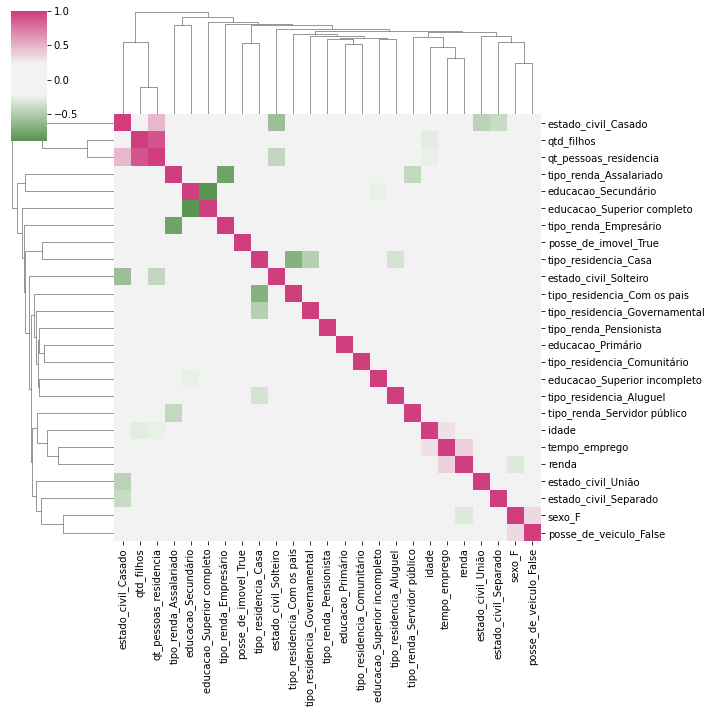

In [37]:
cmap = sns.diverging_palette(h_neg=125, h_pos=350, as_cmap=True, sep=60, center='light')
sns.clustermap(df_dummies_renda.corr(),figsize=(10,10), center=0, cmap=cmap)


In [38]:
renda_train = x_train
renda_train.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace = True)
renda_train['renda']=y_train

y, X = patsy.dmatrices('np.log(renda) ~  idade + tempo_emprego + sexo_F + posse_de_veiculo_False + estado_civil_Casado + qt_pessoas_residencia', renda_train)
modelo = sm.OLS(y,X).fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     663.3
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:48:51   Log-Likelihood:                -9854.4
No. Observations:                9179   AIC:                         1.972e+04
Df Residuals:                    9172   BIC:                         1.977e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.0429      0.044    184.191      0.000       7.957       8.128
idade                      0.0050      0.001      5.754      0.000       0.003       0.007
tempo_emprego              0.0563      0.001     46.329      0.000       0.054       0.059
sexo_F                    -0.6978      0.017    -41.978      0.000      -0.730      -0.665
posse_de_veiculo_False    -0.0560      0.016     -3.483      0.000      -0.088      -0.024
estado_civil_Casado       -0.0147      0.019     -0.775      0.438      -0.052       0.022
qt_pessoas_residencia      0.0216      0.009      2.322      0.020       0.003       0.040
==============================================================================
Omnibus:                        9.808   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.855
Skew:                          -0.078   Prob(JB):                      0.00724
Kurtosis:                       2.964   Cond. No.                         253.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Usando o modelo de correlação e a variável posse de veiculos se mostrando forte na correlação, não consegui ter muito ganho no modelo usando ela, o melhor modelo ainda foi o modelo dado pelo método stepwise.

### Aplicando o modelo otimizado nos dados de testes

In [39]:
renda_teste = x_test
renda_teste.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace = True)
renda_teste['renda']=y_test

y, X = patsy.dmatrices('np.log(renda) ~  idade + tempo_emprego + sexo_F + posse_de_imovel_True + tipo_renda_Assalariado + educacao_Superior_completo', renda_teste)
modelo = sm.OLS(y,X).fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     223.6
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          3.62e-237
Time:                        13:49:43   Log-Likelihood:                -3239.3
No. Observations:                3060   AIC:                             6493.
Df Residuals:                    3053   BIC:                             6535.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      8.1779      0.063    129.481      0.000       8.054       8.302
idade                          0.0042      0.001      2.893      0.004       0.001       0.007
tempo_emprego                  0.0507      0.002     24.874      0.000       0.047       0.055
sexo_F                        -0.7668      0.027    -28.087      0.000      -0.820      -0.713
posse_de_imovel_True           0.0848      0.027      3.196      0.001       0.033       0.137
tipo_renda_Assalariado        -0.1686      0.026     -6.387      0.000      -0.220      -0.117
educacao_Superior_completo     0.1009      0.026      3.859      0.000       0.050       0.152
==============================================================================
Omnibus:                        4.518   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.044
Skew:                          -0.027   Prob(JB):                        0.132
Kurtosis:                       2.830   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Etapa 5 Crisp-DM: Avaliação dos resultados


### Avaliação de outliers
#### Testei com todos os dados sem eliminação de "outliers" e obtive o melhor R2= 0.246, com o método de eliminação de "outliers" do quartil o  melhor R2 que consegui foi de 0.178, e com o método do desvio padrão obtive o melhor R2 de 0,292 (método utilizado no meu trabalho).
 
####   

### Modelo:
#### Devido o alto número de variáveis contida no arquivo, utilizei a técnica stepwise para buscar as variáveis mais relevantes para explicar o resultado da renda. Após o modelo stepwise fazer a seleção das variáveis mais relevantes, trabalhei para otimizar o modelo fazendo vários testes com log, polinômio e standardização. O melhor resultado obtido foi com log em renda, modelo que deixei documentado. Depois disto apliquei o modelo na base de teste para verificar se estava consistente, e na base de teste apresentou um R2 de 0.305 contra um R2 de 0.312 da base de treino. Desta forma, acredito que o modelo está consistente.
#### Importante dizer que também tentei buscar um modelo utilizando o gráfico de correlação, mas nenhum modelo se mostrou melhor do que o stepwise. Outro ponto importante, mesmo a variável pose de veículo se mostrando forte na correlação, o modelo stepwise não há selecionou. Isto caoousou uma dúvida em mim, mas segui com o modelo sem ela, pois foi onde obtive o melhor R2.

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

### Gravando coeficentes em um arquvivo CSV para ser usado na otimização

In [40]:
coef = {'Intercept':[modelo.params[0]],
        'idade':[modelo.params[1]],
        'tempo_emprego':[modelo.params[2]],
        'sexo_F':[modelo.params[3]],
        'posse_de_imovel_True':[modelo.params[4]],
        'tipo_renda_Assalariado':[modelo.params[5]],
        'educacao_Superior_completo':[modelo.params[6]]}
df_coef = pd.DataFrame(data=coef)

#Atualizando e Guardando coeficentes para ser utilizado em ooutros programas se for o caso
df_coef.to_csv('./input/coeficentes.csv', index=False)



### Rotina para prever renda conforme parâmetros informados pelo usuário.

In [41]:
#Parâmetros de entrada para o cálculo da renda. Segue um exemplo de motor de tomada de decisão. 
#Dados os parâmetros de entrada o motor retorna a renda prevista.  
n_idade=28
n_tempo_emprego=8.47
n_sexo_F=1
n_posse_de_imovel_True=1
n_tipo_renda_Assalariado=0
n_educacao_Superior_completo= 0

#Equação para determinação da renda baseado na idade, tempo de emprego, sexo, posse de imóvel, tipo renda e educação
resultado_renda = df_coef['Intercept'] + (df_coef['idade'] * n_idade) + (df_coef['tempo_emprego'] * n_tempo_emprego) + (df_coef['sexo_F'] * n_sexo_F) + (df_coef['posse_de_imovel_True'] * n_posse_de_imovel_True) + (df_coef['tipo_renda_Assalariado'] * n_tipo_renda_Assalariado) + (df_coef['educacao_Superior_completo'] * n_educacao_Superior_completo) 
resultado = np.exp(resultado_renda)
round(resultado[0],2)

3111.32